# Using the low-level API from HSSM directly with PyMC

In addition to the high-level API that relies on `bambi` for model creation, HSSM also features a low-level API that it internally calls for creating `pytensor` `Op`s and `pm.Distribution`s. Experienced users can use the low-level API directly with `PyMC` to create even more customized models. This tutorial shows how advanced users can utilize the low-level API that HSSM offers to interface with PyMC.

## Colab Instructions

If you would like to run this tutorial on Google colab, please click this [link](https://github.com/lnccbrown/HSSM/blob/main/docs/tutorial_notebooks/no_execute/main_tutorial.ipynb). 

Once you are *in the colab*, follow the *installation instructions below* and then **restart your runtime**. 

Just **uncomment the code in the next code cell** and run it!

**NOTE**:

You may want to *switch your runtime* to have a GPU or TPU. To do so, go to *Runtime* > *Change runtime type* and select the desired hardware accelerator.

Note that if you switch your runtime you have to follow the installation instructions again.

In [ ]:
# !pip install numpy==1.23.4
# !pip install git+https://github.com/lnccbrown/hssm@main
# !pip install git+https://github.com/brown-ccv/hddm-wfpt@main
# !pip install numpyro

## Load Modules

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import ssms.basic_simulators

from hssm.distribution_utils import (
    make_distribution,  # A general function for making Distribution classes
    make_distribution_from_onnx,  # Makes Distribution classes from onnx files
    make_distribution_from_blackbox,  # Makes Distribution classes from callables
)

# pm.Distributions that represents the top-level distribution for
# DDM models (the Wiener First-Passage Time distribution)
from hssm.likelihoods import logp_ddm_sdv, DDM
from hssm.utils import download_hf

pytensor.config.floatX = "float32"

## Build a model directly from PyMC

With `DDM` and `DDM_SDV` which are `pm.Distribution`s, we can create models directly with PyMC. We first simulate some data using `ssm_simulators` and then use `PyMC` to specify the model and sample from the it.

In [2]:
# Simulate some data
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.5]
obs_ddm = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true], model="ddm", n_samples=1000
)
obs_ddm = np.column_stack([obs_ddm["rts"][:, 0], obs_ddm["choices"][:, 0]])
dataset = pd.DataFrame(obs_ddm, columns=["rt", "response"])

dataset

,rt,response
0,2.301028,-1.0
1,1.682999,1.0
2,1.068996,1.0
3,1.269994,-1.0
4,2.079018,1.0
...,...,...
995,2.088018,1.0
996,2.479036,1.0
997,1.842007,1.0
998,1.328993,-1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, a, z, t]


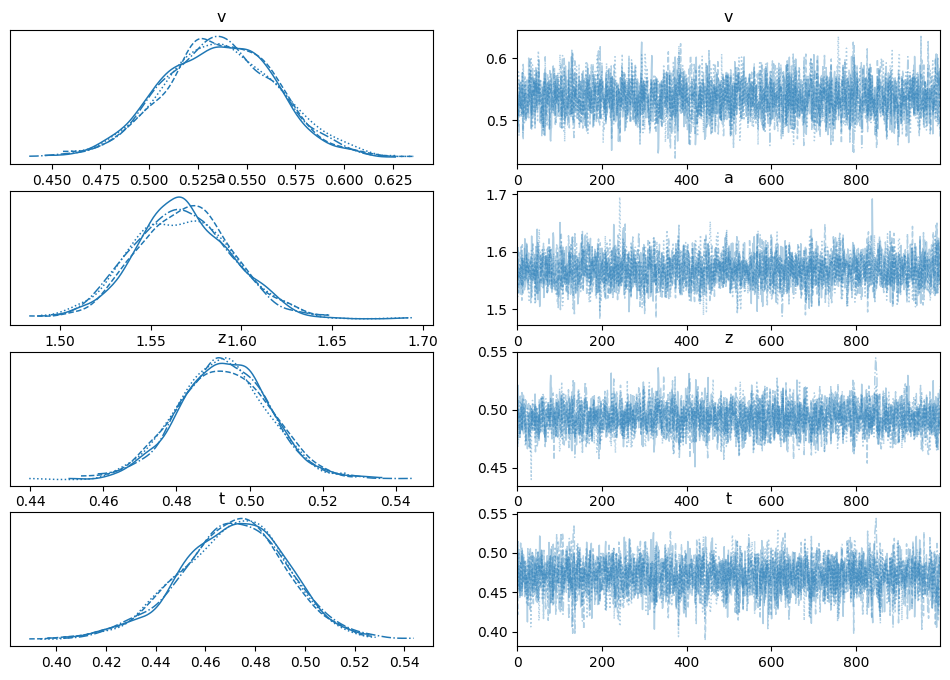

In [3]:
with pm.Model() as ddm_pymc:
    v = pm.Uniform("v", lower=-10.0, upper=10.0)
    a = pm.HalfNormal("a", sigma=2.0)
    z = pm.Uniform("z", lower=0.01, upper=0.99)
    t = pm.Uniform("t", lower=0.0, upper=0.6, initval=0.1)

    ddm = DDM("ddm", v=v, a=a, z=z, t=t, observed=dataset.values)

    ddm_pymc_trace = pm.sample()

az.plot_trace(ddm_pymc_trace);

## Building top-level distributions with `distribution_utils`

### `make_distribution` and `make_distribution_from_blackbox`

The above example shows that, as long as the top-level distribution is known, modeling can be done in `PyMC` as well without using `Bambi`. However, as [this official `PyMC` tutorial](https://www.pymc.io/projects/docs/en/v4.0.1/contributing/developer_guide_implementing_distribution.html) shows, creating a distribution in PyMC can be a time consuming-task. You will need to create a `RandomVariable` first and then define your custom `Distribution` by extending `pm.Distribution` class. From `PyMC 5.0.0` on, `pm.CustomDist` simplifies this process, but the use case is not applicable to complex likelihoods in HSSM. Fortunately, HSSM provides many convenience functions in its `distribution_utils` submodule that make this process easy. Next, we use another example to show how we can use these functions to create custom `pm.Distribution`s to be used with `PyMC`.

Suppose we have a likelihood function for DDM models with standard deviations for `v` written. This model has 5 parameters: `v, a, z, t, sv`, and we want to use this function as the likelihood to create a `pm.Distribution` for modeling with `PyMC`. We can use `make_distribution` for this purpose.

**Note**
This distribution is already available in HSSM at `hssm.likelihoods.DDM_SDV`. For illustration purposes, we go through the process in which this distribution is created. We can use the same procedure for other distributions not currently available in HSSM.

In [4]:
DDM_SDV = make_distribution(
    rv="ddm_sdv",
    loglik=logp_ddm_sdv,
    list_params=["v", "a", "z", "t", "sv"],
    bounds={"t": (0, 1)},
)

Now we have a `pm.Distribution` that can be used for modeling in `PyMC`. The procedure is very similar to the one described in the previous section, so we will omit it here. Let's instead focus on the parameters for `make_distribution`.

- `rv`: a `str` or a `RandomVariable`. If a `str` is provided, a `RandomVariable` class will be created automatically. This `RandomVariable` will use the `str` to identify a simulator provided in the `ssm_simulators` package as its `rng_fn` (sampling) function. If this `str` is not one of the entries to the `model_config` `dict` specified [here](https://github.com/AlexanderFengler/ssm-simulators/blob/main/ssms/config/config.py), then the `Distribution` will still be created but with a warning that any attempt to sample from the `RandomVariable` will result in an Error. That includes sampling from the posterior distribution. The user could create his/her own `RandomVariable` class and define its `rng_fn` class method for sampling.

- `loglik`: an `Op` or a `Callable`. HSSM assumes that the `Callable` to be written with `pytensor` functions and can be compiled into a `pytensor` computation graph. If that is not the case, please use `make_distribution`'s close sibling `make_distribution_from_blackbox`, which will first wrap the `Callable` in an `Op` and then create the `pm.Distribution`. The signature of `make_distribution_from_blackbox` is almost identical to that of `make_distribution`.

  The function signature for the `Op` or `Callable` has to follow a specific pattern. Please refer to [this section](../tutorial_likelihoods.md#using-custom-likelihoods) for more details.

- `list_params`: a list of `str`s specifying the parameters used in the model. **Note** the order in which the parameters are defined in this list is __very__ important! In principle it has to be consistent with the order in which parameters are passed to the `Op` or `Callable` specified with `loglik`.

- `bounds`: a `dict` of `param : (lower, upper)` specifying the range of values that each parameter can take. HSSM currently does not support specifying `inf` or `-inf` as bounds but will in an update in the near future.

### Create distribution from `onnx` networks with `make_distribution_from_onnx`

It is also possible to create a `pm.Distribution` from a neural network defined in an `onnx` file. The `onnx` file will be automatically translated to either `jax` or `pytensor` functions. The following example shows how to download an `onnx` model from [the official HSSM model repository](https://huggingface.co/franklab/HSSM) and use `make_distribution_from_onnx` to create the distribution.

In [5]:
angle_onnx = download_hf("angle.onnx")

Angle = make_distribution_from_onnx(
    rv="angle",
    list_params=["v", "a", "z", "t", "theta"],
    onnx_model=angle_onnx,
    backend="jax",
    bounds={
        "v": (-3.0, 3.0),
        "a": (0.3, 3.0),
        "z": (0.1, 0.9),
        "t": (0.001, 2.0),
        "theta": (-0.1, 1.3),
    },
    params_is_reg=[False] * 5,
)

`make_distribution_from_onnx` has a very similar API to that of `make_distribution`, instead of asking for a `loglik`, it requires an `onnx_model`, which can be a `str`, a `PathLike`, or an `onnx` model already loaded in memory with `onnx.load()` from the `onnx` package. The detailed explanation of `backend` can be found [here](../tutorial_likelihoods.md#3-kinds-of-likelihoods).

One important parameter for `make_distribution_from_onnx` is `params_is_reg`. It accepts a list of `bool`s the same length as `list_params`. Each of the `bool`s indicates whether the corresponding parameter in `list_params` is the target of a regression. HSSM needs this information to determine the dimensions of the parameter values passed to the `logp` function for the `pm.Distribution` created when MCMC sampling is performed and apply appropriate broadcasting before these values are fed to the neural network. When omitted, it is assumed that none of the parameters is the target of a regression.